In [1]:
import sys
sys.path.append('../')
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *

import re

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
k = 10 # Top 10% highest l2-magnitude filters

In [4]:
def mean_direction(angles, r):
    angles = (angles)
    n = angles.shape[0]
    print(n)

    C = np.sum(r*np.cos(angles))
    S = np.sum(r*np.sin(angles))
    return C,S
    #return C,S
    print(C,S)
    if S > 0 and C > 0:
        return (np.arctan2(S,C))
    if C < 0:
        return (np.arctan2(S,C) + np.pi )
    if S<0 and C > 0:
        print(1)
        return (np.arctan2(S,C) + 2*np.pi)


 ============ LAYER 0 ==================
(64, 3, 3, 3) (64, 3, 3, 3) (64, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
f (3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
(1, 3, 3, 3) (1, 3, 3, 3) (1, 3, 3, 3)
block1_conv1


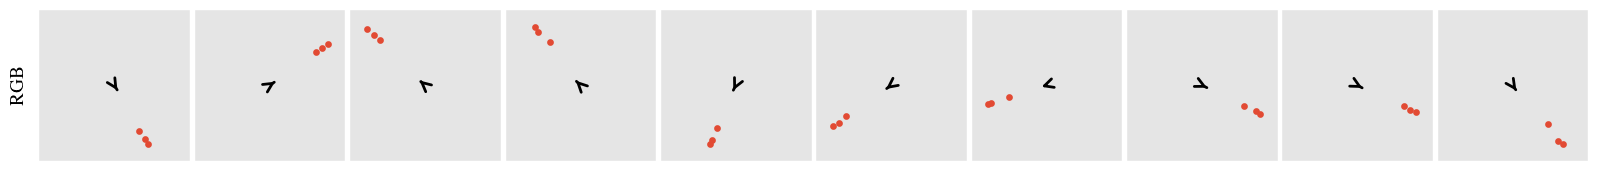

In [5]:
layers = [0]

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '200'})
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (7, 7) or l.kernel_size == (3,3):
			conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []
plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
fig= plt.figure(figsize = (10,len(layers)))
fig.clf()

#fig.tight_layout()
gs1 = gridspec.GridSpec(len(layers), 10)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
ax = [fig.add_subplot(ss) for ss in gs1]
ax = np.reshape(ax, (len(layers), 10))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)


#fig.set_tight_layout(True)
for l, l_num in enumerate(layers):
	print(f" ============ LAYER {l_num} ==================")

	filters, _ = conv_layers[l_num].get_weights()

	s, a = getSymAntiSymTF(filters)
	#theta = getSobelTF(filters)
	a_energy = reduce_euclidean_norm(a, axis=[0,1])**2
	s_energy = reduce_euclidean_norm(s, axis=[0,1])**2
	total_energy  = reduce_euclidean_norm(filters, axis=[0,1])**2
	#beta = a_energy/total_energy
	beta = tf.reduce_mean(a_energy/total_energy, (0))

	fs = []

	for i in range(filters.shape[-1]):
		fs.append((filters[:,:, :,i], beta[i]))

	fs = sorted(fs, key=lambda f: f[1], reverse=True)





	for i, (f, beta) in enumerate(fs[:10]):
		print("f", f.shape)
		s, a = getSymAntiSymTF(tf.expand_dims(f, -1))
		theta = getSobelTF(tf.expand_dims(f, -1))
		dvec, dtheta = getDominantAngle(tf.expand_dims(f, -1))

		a_mag = reduce_euclidean_norm(a, axis=[0,1])

		x =a_mag*np.cos((theta))
		y = a_mag*np.sin((theta))
		#c,s = mean_direction(theta[:,i], a_mag[:,i])
		#print(d)
		lim_x = np.max(np.abs(x))
		lim_y = np.max(np.abs(y))
		lim = np.max([lim_x, lim_y])
		lim *= 1.3

		e_vec = dvec[0]

		#ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
		#ax[l_num, i].set_rasterization_zorder(1)
		ax[l, i].set_xlim(-lim, lim)
		ax[l, i].set_ylim(-lim, lim)
		ax[l, i].scatter(x,y, s=2, color='#E24A33')
		ax[l, i].set_box_aspect(1)

		ax[l, i].set_xticks([])
		ax[l, i].set_yticks([])
		ax[l, i].set_aspect('equal')
		#ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
		#ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
		
		ax[l, i].annotate("", xy=(e_vec[0]*.1, e_vec[1]*.1), xytext=(0, 0), 
					arrowprops=dict(arrowstyle="->",  color='black', lw=None))
		ax[l, i].collections[0].set_rasterized(True)

		#ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")
for i, l_num in enumerate(layers):

	print(conv_layers[0].name)
	match = re.search(r"conv(\d+)_block(\d+)", conv_layers[l_num].name)
	if match is None:
		match = re.search(r"conv(\d+)_conv", conv_layers[l_num].name)
		ax[i, 0].set_ylabel(f"RGB", fontsize=7) 
		continue

	ax[i, 0].set_ylabel(f"{i+1}\nc{match.group(1)}_b{match.group(2)}", fontsize=7) 

#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)




In [6]:
#fig.subplots_adjust(wspace=0.025, hspace=0.025)
#plt.show()

In [ ]:
fig.savefig('../figures/resnet_bipol.pdf', dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../figures/resnet_bipol.pdf'

: 